# Project Demo
Demonstration of using Mask-RCNN to localize objects for robotic grasping. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io
from IPython.display import clear_output
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.project import project

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to project trained weights
PROJECT_WEIGHTS_PATH = "/home/john/COMP5212_Machine_Learning/Project/Mask_RCNN/mask_rcnn_project.h5"  # TODO: update this path

# IMPORT ROS
import rospy
from std_msgs.msg import String
from maskrcnn.msg import int_list
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')
print(sys.path)
import cv2

Using TensorFlow backend.


['', '/home/john/test_ws/devel/lib/python2.7/dist-packages', '/home/john/catkin_ws/devel/lib/python2.7/dist-packages', '/home/john/anaconda3/envs/MaskRCNN-GPU/lib/python36.zip', '/home/john/anaconda3/envs/MaskRCNN-GPU/lib/python3.6', '/home/john/anaconda3/envs/MaskRCNN-GPU/lib/python3.6/lib-dynload', '/home/john/anaconda3/envs/MaskRCNN-GPU/lib/python3.6/site-packages', '/home/john/anaconda3/envs/MaskRCNN-GPU/lib/python3.6/site-packages/IPython/extensions', '/home/john/.ipython', '/home/john/COMP5212_Machine_Learning/Project/Mask_RCNN_submission', '/home/john/COMP5212_Machine_Learning/Project/Mask_RCNN_submission/samples', '/home/john/COMP5212_Machine_Learning/Project/Mask_RCNN_submission']


## Configurations

In [2]:
config = project.ProjectConfig()
PROJECT_DIR = os.path.join(ROOT_DIR, "datasets/project")

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
# Load validation dataset
dataset = project.ProjectDataset()
dataset.load_project(PROJECT_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 12
Classes: ['BG', 'gripper', 'cube', 'cylinder', 'grasp']


## Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [8]:
# Set path to project weights file

# Load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/john/COMP5212_Machine_Learning/Project/Mask_RCNN_submission/logs/project20181118T0113/mask_rcnn_project_0012.h5
Re-starting from epoch 12


## Run Object Detection

In [9]:
def object_localizer():    
    pub = rospy.Publisher('chatter', int_list, queue_size=10)
    rospy.init_node('talker', anonymous=True)
    rate = rospy.Rate(10) # 10hz
    position_list = int_list()
    while not rospy.is_shutdown():
        time_0=time.time()
        
        #Webcam
        #cap = cv2.VideoCapture(1)
        #ret, frame = cap.read()
        #cap.release()
        #image = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        
        #Validation set
        image_id = random.choice(dataset.image_ids)
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
        
        
        
        gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
        results = model.detect([gray], verbose=1)
        r = results[0]
        ax = get_ax(1)
        visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
        
        position=np.zeros(shape=(r['masks'].shape[2],7))
        for i in range(0,r['masks'].shape[2]):
            mask = r['masks'][:,:,i]
            [y, x] = np.round(np.average(np.nonzero(mask), 1))
            [height, width] = np.round(np.amax(np.nonzero(mask),1)-np.amin(np.nonzero(mask),1))
            [maximum, d] = np.round(np.amax(np.nonzero(mask),1))
            [minimum, d] = np.round(np.amin(np.nonzero(mask),1))
            [class_id, class_name] = [r['class_ids'][i],dataset.class_names[r['class_ids'][i]]] 
            position[i][:]=[x, y, width, height, maximum, minimum, class_id]
            plt.scatter(x, y, s=100, c='blue', marker='o')
        clear_output(wait=True)
        plt.show()
        plt.draw()
        position = np.reshape(position, position.size)
        position = position.tolist()
        rate.sleep()
        time_1=time.time()
        cpu_period = time_1-time_0
        position_list.data = np.append(position, cpu_period)
        pub.publish(position_list)    

<Figure size 432x288 with 0 Axes>

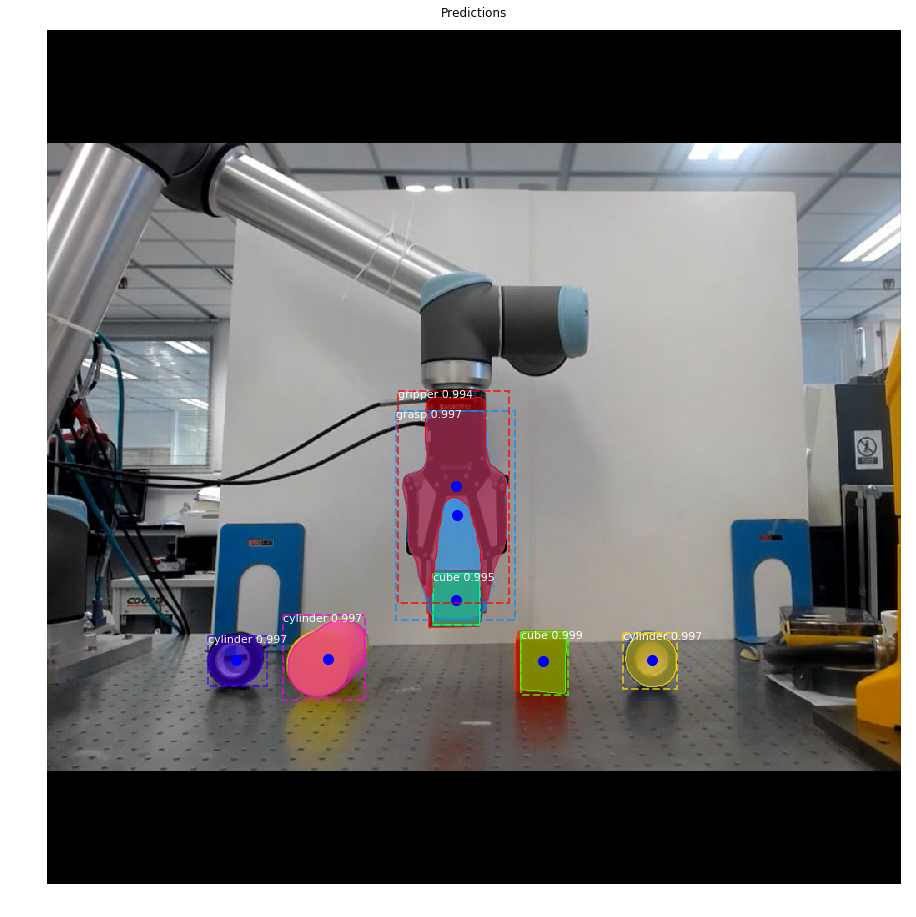

<Figure size 432x288 with 0 Axes>

In [10]:
if __name__ == '__main__':
    try:
        object_localizer()
    except rospy.ROSInterruptException:
        pass